In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium import plugins

Loading and organizing the data

In [2]:
NeighbourhoodsWithCrime = gpd.read_file('NeighbourhoodsWithCrime.json')

In [3]:
#Making sure numerical data is not in string type
numeric_columns = [
    'Population', 'Average Age', 'Median Age', 'Average Total Income in 2020',
    'Immigrants', 'Immigrants_Percentage', 'Non-Immigrants', 'Non-Immigrants_Percentage',
    'Employed', 'Employed_Percentage', 'Unemployed', 'Unemployed_Percentage',
    'No Degree', 'No Degree_Percentage', 'High School Diploma', 'High School Diploma_Percentage',
    'Postsecondary Certificate', 'Postsecondary Certificate_Percentage', "Bachelor's", 
    "Bachelor's_Percentage", "Master's", "Master's_Percentage", 'Doctorate', 'Doctorate_Percentage'
]

# Convert these columns to numeric (using 'coerce' to handle errors like invalid characters)
for col in numeric_columns:
    NeighbourhoodsWithCrime[col] = pd.to_numeric(NeighbourhoodsWithCrime[col], errors='coerce')

In [4]:
#Add total thefts column
NeighbourhoodsWithCrime['Total Thefts'] = (NeighbourhoodsWithCrime['Bike Thefts'] +
                                             NeighbourhoodsWithCrime['Car Thefts'])
#Add crime normalized by neighbourhood area column
NeighbourhoodsWithCrime['Bike thefts by Area'] = (NeighbourhoodsWithCrime['Bike Thefts']/NeighbourhoodsWithCrime['neighbourhood_area'])
NeighbourhoodsWithCrime['Car thefts by Area'] = (NeighbourhoodsWithCrime['Car Thefts']/NeighbourhoodsWithCrime['neighbourhood_area'])
NeighbourhoodsWithCrime['Total thefts by Area'] = (NeighbourhoodsWithCrime['Total Thefts']/NeighbourhoodsWithCrime['neighbourhood_area'])

#Add crime normalized by population column
NeighbourhoodsWithCrime['Bike thefts by Population'] = (NeighbourhoodsWithCrime['Bike Thefts']/NeighbourhoodsWithCrime['Population'])
NeighbourhoodsWithCrime['Car thefts by Population'] = (NeighbourhoodsWithCrime['Car Thefts']/NeighbourhoodsWithCrime['Population'])
NeighbourhoodsWithCrime['Total thefts by Population'] = (NeighbourhoodsWithCrime['Total Thefts']/NeighbourhoodsWithCrime['Population'])

#Add population density column
NeighbourhoodsWithCrime['Population Density'] = NeighbourhoodsWithCrime['Population']/NeighbourhoodsWithCrime['neighbourhood_area']

#Add rank columns
NeighbourhoodsWithCrime['Education Rank'] = NeighbourhoodsWithCrime['No Degree_Percentage'].rank(ascending=True).astype(int)
NeighbourhoodsWithCrime['Unemployment Rank'] = NeighbourhoodsWithCrime['Unemployed_Percentage'].rank(ascending=False).astype(int)
NeighbourhoodsWithCrime['Income Rank'] = NeighbourhoodsWithCrime['Average Total Income in 2020'].rank(ascending=False).astype(int)
NeighbourhoodsWithCrime['Park Density Rank'] = NeighbourhoodsWithCrime['Park Density'].rank(ascending=False).astype(int)

Start plotting

# Correlation matrix

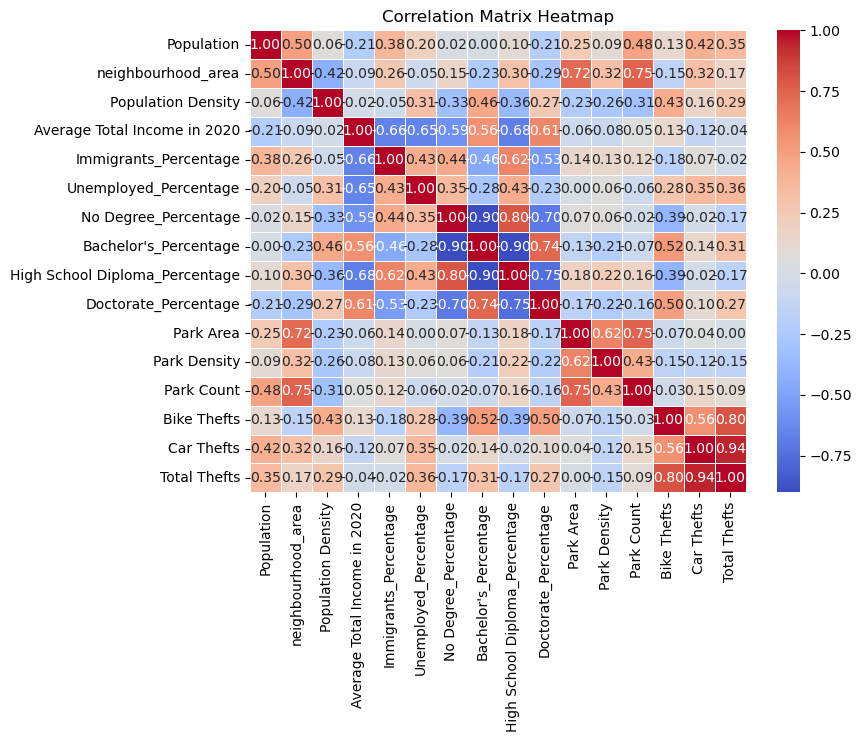

In [5]:
columns_of_interest = ['Population','neighbourhood_area','Population Density', 'Average Total Income in 2020',
                       'Immigrants_Percentage','Unemployed_Percentage', 'No Degree_Percentage', 
                       'Bachelor\'s_Percentage','High School Diploma_Percentage','Doctorate_Percentage', 
                       'Park Area', 'Park Density', 'Park Count', 'Bike Thefts', 'Car Thefts', 'Total Thefts']

# Calculate the correlation matrix for the selected columns
correlation_matrix = NeighbourhoodsWithCrime[columns_of_interest].corr()

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [6]:
NeighbourhoodsWithCrime['Car Thefts'].sum()

57036

In [7]:
NeighbourhoodsWithCrime['Bike Thefts'].sum()

17007

In [8]:
NeighbourhoodsWithCrime = NeighbourhoodsWithCrime.set_geometry('geometry')

# Thefts by population

In [9]:
#Bike

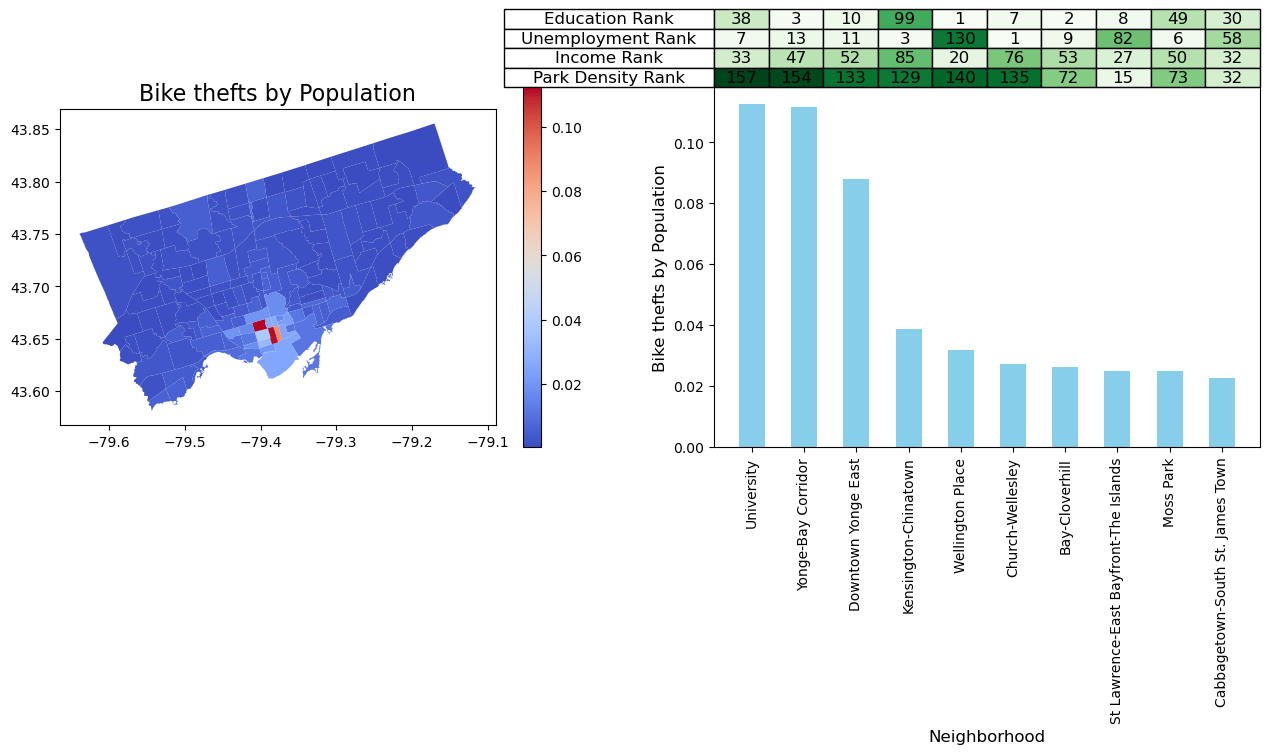

In [10]:
NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by='Bike thefts by Population', ascending=False)
top_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)

# Data for the bar chart (top 10 neighborhoods)
labels = top_10_neighbourhoods['Neighbourhood Name']
values = top_10_neighbourhoods['Bike thefts by Population']

# Create additional data for the table (for demonstration)
additional_data = top_10_neighbourhoods[['Education Rank', 'Unemployment Rank', 
                                          'Income Rank', 'Park Density Rank']].values

# Create row descriptions
descriptions = ['Education Rank', 'Unemployment Rank', 'Income Rank', 'Park Density Rank']

# Create a figure with two subplots (map and bar+table)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Plot the heatmap on the first axis
NeighbourhoodsWithCrime.plot(column='Bike thefts by Population',  # Column to color by
                             cmap='coolwarm',  # Color map to use
                             legend=True,      # Show legend
                             ax=ax[0])         # Plot on the first axis
ax[0].set_title('Bike thefts by Population', fontsize=16)

# Create the bar chart on the second axis
bars = ax[1].bar(labels, values, color='skyblue', width=0.5)

# Add labels and title to the bar chart
ax[1].set_xlabel('Neighborhood', fontsize=12)
ax[1].set_ylabel('Bike thefts by Population', fontsize=12)

# Ensure the data is structured correctly for the table
cell_text = additional_data.T  # Transpose to match columns as rows in the table
columns = labels.tolist()  # Convert to list for proper alignment in the table
rowLabels = descriptions  # The rows correspond to rank descriptions

# Create the colormap for coloring the table cells
colormap = plt.get_cmap('Greens')

# Normalize the additional data values to match the color map
norm = plt.Normalize(np.min(cell_text), np.max(cell_text))  # Normalize data to the colormap

# Create the table above the bar chart
table = ax[1].table(cellText=cell_text, colLabels=None, rowLabels=rowLabels, loc='top', 
                    cellLoc='center', rowLoc='center')

# Apply colors to the cells
for (i, j), val in np.ndenumerate(cell_text):
    # Map the value to the colormap
    color = colormap(norm(val))  # Apply colormap normalization
    table[(i, j)].set_facecolor(color)

# Disable auto font size adjustment for the table
table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(1, 2)

# Adjust layout to make room for the table and keep it aligned with the bars
plt.subplots_adjust(left=0.1, bottom=0.3, top=0.75)  # Increase the 'top' value to make room for the table

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [11]:
#Car

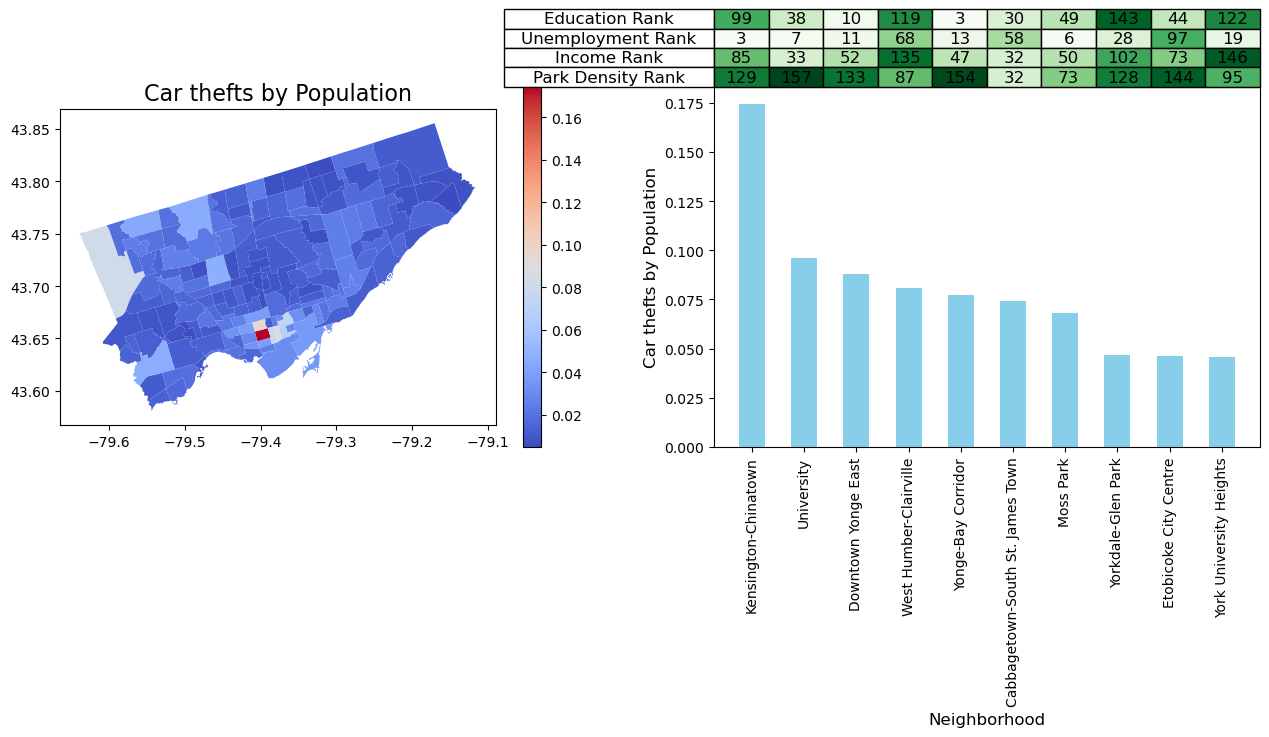

In [12]:
NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by='Car thefts by Population', ascending=False)
top_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)

# Data for the bar chart (top 10 neighborhoods)
labels = top_10_neighbourhoods['Neighbourhood Name']
values = top_10_neighbourhoods['Car thefts by Population']

# Create additional data for the table (for demonstration)
additional_data = top_10_neighbourhoods[['Education Rank', 'Unemployment Rank', 
                                          'Income Rank', 'Park Density Rank']].values

# Create row descriptions
descriptions = ['Education Rank', 'Unemployment Rank', 'Income Rank', 'Park Density Rank']

# Create a figure with two subplots (map and bar+table)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Plot the heatmap on the first axis
NeighbourhoodsWithCrime.plot(column='Car thefts by Population',  # Column to color by
                             cmap='coolwarm',  # Color map to use
                             legend=True,      # Show legend
                             ax=ax[0])         # Plot on the first axis
ax[0].set_title('Car thefts by Population', fontsize=16)

# Create the bar chart on the second axis
bars = ax[1].bar(labels, values, color='skyblue', width=0.5)

# Add labels and title to the bar chart
ax[1].set_xlabel('Neighborhood', fontsize=12)
ax[1].set_ylabel('Car thefts by Population', fontsize=12)

# Ensure the data is structured correctly for the table
cell_text = additional_data.T  # Transpose to match columns as rows in the table
columns = labels.tolist()  # Convert to list for proper alignment in the table
rowLabels = descriptions  # The rows correspond to rank descriptions

# Create the colormap for coloring the table cells
colormap = plt.get_cmap('Greens')

# Normalize the additional data values to match the color map
norm = plt.Normalize(np.min(cell_text), np.max(cell_text))  # Normalize data to the colormap

# Create the table above the bar chart
table = ax[1].table(cellText=cell_text, colLabels=None, rowLabels=rowLabels, loc='top', 
                    cellLoc='center', rowLoc='center')

# Apply colors to the cells
for (i, j), val in np.ndenumerate(cell_text):
    # Map the value to the colormap
    color = colormap(norm(val))  # Apply colormap normalization
    table[(i, j)].set_facecolor(color)

# Disable auto font size adjustment for the table
table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(1, 2)

# Adjust layout to make room for the table and keep it aligned with the bars
plt.subplots_adjust(left=0.1, bottom=0.3, top=0.75)  # Increase the 'top' value to make room for the table

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [13]:
#Total

In [14]:
NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by='Total thefts by Population', ascending=True)
bottom_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)
list3 = bottom_10_neighbourhoods['Neighbourhood Name'].tolist();
NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by='Total thefts by Population', ascending=False)
top_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)
list1 = top_10_neighbourhoods['Neighbourhood Name'].tolist();

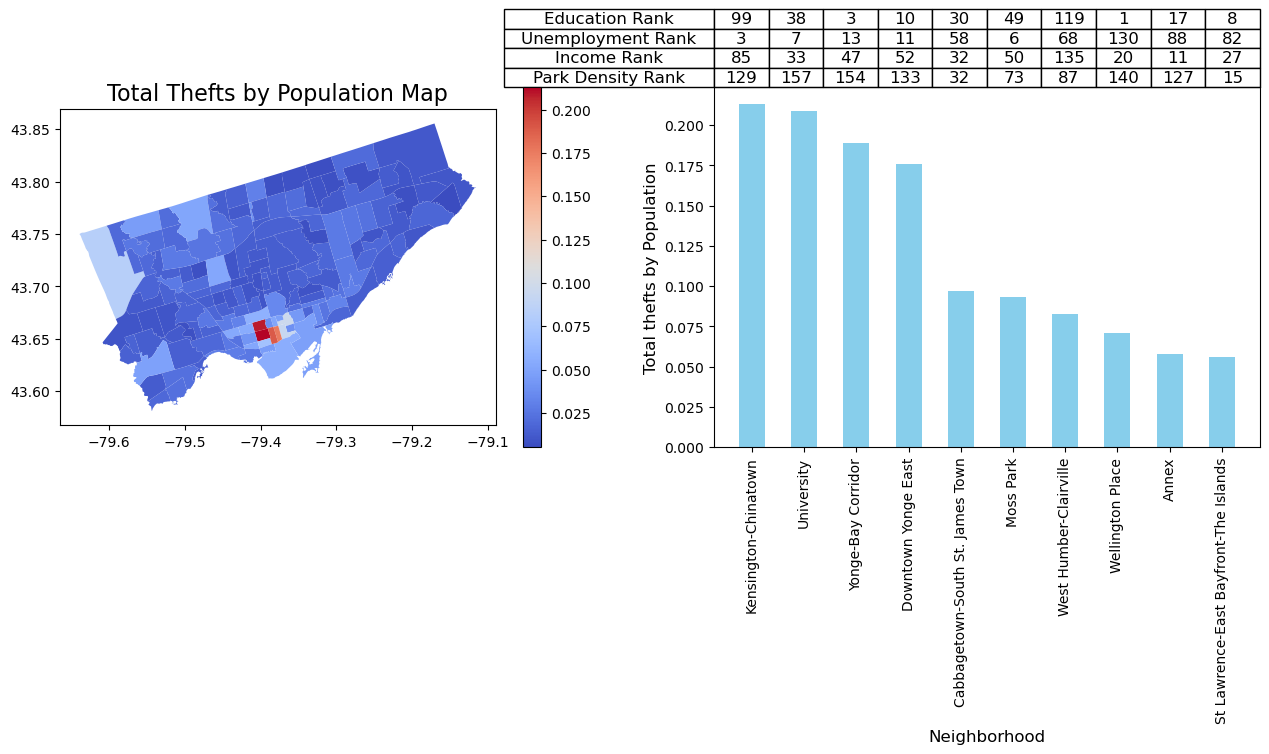

In [15]:
# Data for the bar chart (top 10 neighborhoods)
labels = top_10_neighbourhoods['Neighbourhood Name']
values = top_10_neighbourhoods['Total thefts by Population']

# Create additional data for the table (for demonstration)
# Ensure that the additional columns are available in the DataFrame
additional_data = top_10_neighbourhoods[['Education Rank', 'Unemployment Rank', 
                                          'Income Rank', 'Park Density Rank']].values

# Create row descriptions
descriptions = ['Education Rank', 'Unemployment Rank', 'Income Rank', 'Park Density Rank']

# Create a figure with two subplots (the map will be in the first, the bar+table in the second)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Plot the heatmap (no changes here)
NeighbourhoodsWithCrime.plot(column='Total thefts by Population',  # Column to color by
                             cmap='coolwarm',  # Color map to use
                             legend=True,      # Show legend
                             ax=ax[0])         # Plot on the first axis
ax[0].set_title('Total Thefts by Population Map', fontsize=16)

# Create the bar chart on the second axis
bars = ax[1].bar(labels, values, color='skyblue',width=0.5)

# Add labels and title to the bar chart
ax[1].set_xlabel('Neighborhood', fontsize=12)
ax[1].set_ylabel('Total thefts by Population', fontsize=12)

# Ensure the data is structured correctly for the table
cell_text = additional_data.T  # Transpose to match columns as rows in the table
# The columns will be the neighborhood names
columns = labels.tolist()  # Convert to list for proper alignment in the table
# The rows will correspond to the rank descriptions
rowLabels = descriptions

# Create the table above the bar chart for the top 10 neighborhoods
table = ax[1].table(cellText=cell_text, colLabels=None, rowLabels=rowLabels, loc='top', 
                    cellLoc='center', rowLoc='center')
table.auto_set_font_size(False)  # Disable auto font size adjustment
table.set_fontsize(12) 
table.scale(1, 2)
# Adjust layout to make room for the table and keep it aligned with the bars
plt.subplots_adjust(left=0.1, bottom=0.3, top=0.75)  # Increase the 'top' value to make room for the table

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

# Thefts by area

In [16]:
#Bike

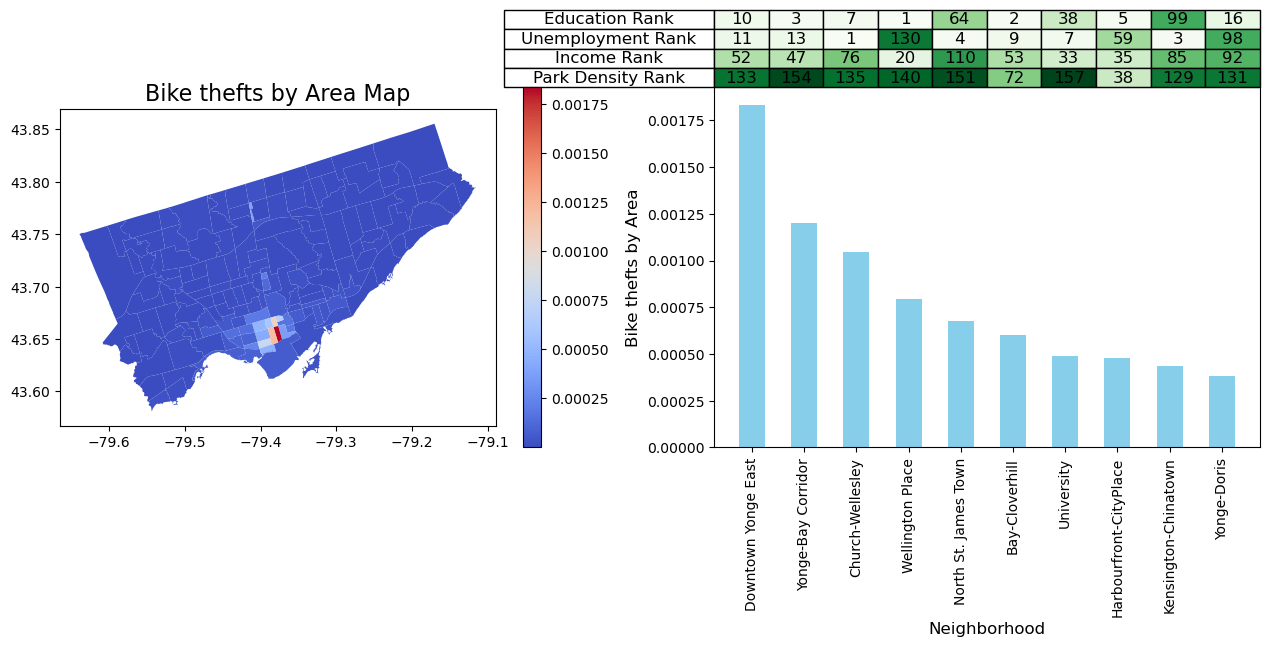

In [17]:
NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by='Bike thefts by Area', ascending=False)
top_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)

# Data for the bar chart (top 10 neighborhoods)
labels = top_10_neighbourhoods['Neighbourhood Name']
values = top_10_neighbourhoods['Bike thefts by Area']

# Create additional data for the table (for demonstration)
additional_data = top_10_neighbourhoods[['Education Rank', 'Unemployment Rank', 
                                          'Income Rank', 'Park Density Rank']].values

# Create row descriptions
descriptions = ['Education Rank', 'Unemployment Rank', 'Income Rank', 'Park Density Rank']

# Create a figure with two subplots (map and bar+table)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Plot the heatmap on the first axis
NeighbourhoodsWithCrime.plot(column='Bike thefts by Area',  # Column to color by
                             cmap='coolwarm',  # Color map to use
                             legend=True,      # Show legend
                             ax=ax[0])         # Plot on the first axis
ax[0].set_title('Bike thefts by Area Map', fontsize=16)

# Create the bar chart on the second axis
bars = ax[1].bar(labels, values, color='skyblue', width=0.5)

# Add labels and title to the bar chart
ax[1].set_xlabel('Neighborhood', fontsize=12)
ax[1].set_ylabel('Bike thefts by Area', fontsize=12)

# Ensure the data is structured correctly for the table
cell_text = additional_data.T  # Transpose to match columns as rows in the table
columns = labels.tolist()  # Convert to list for proper alignment in the table
rowLabels = descriptions  # The rows correspond to rank descriptions

# Create the colormap for coloring the table cells
colormap = plt.get_cmap('Greens')

# Normalize the additional data values to match the color map
norm = plt.Normalize(np.min(cell_text), np.max(cell_text))  # Normalize data to the colormap

# Create the table above the bar chart
table = ax[1].table(cellText=cell_text, colLabels=None, rowLabels=rowLabels, loc='top', 
                    cellLoc='center', rowLoc='center')

# Apply colors to the cells
for (i, j), val in np.ndenumerate(cell_text):
    # Map the value to the colormap
    color = colormap(norm(val))  # Apply colormap normalization
    table[(i, j)].set_facecolor(color)

# Disable auto font size adjustment for the table
table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(1, 2)

# Adjust layout to make room for the table and keep it aligned with the bars
plt.subplots_adjust(left=0.1, bottom=0.3, top=0.75)  # Increase the 'top' value to make room for the table

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [18]:
#Car

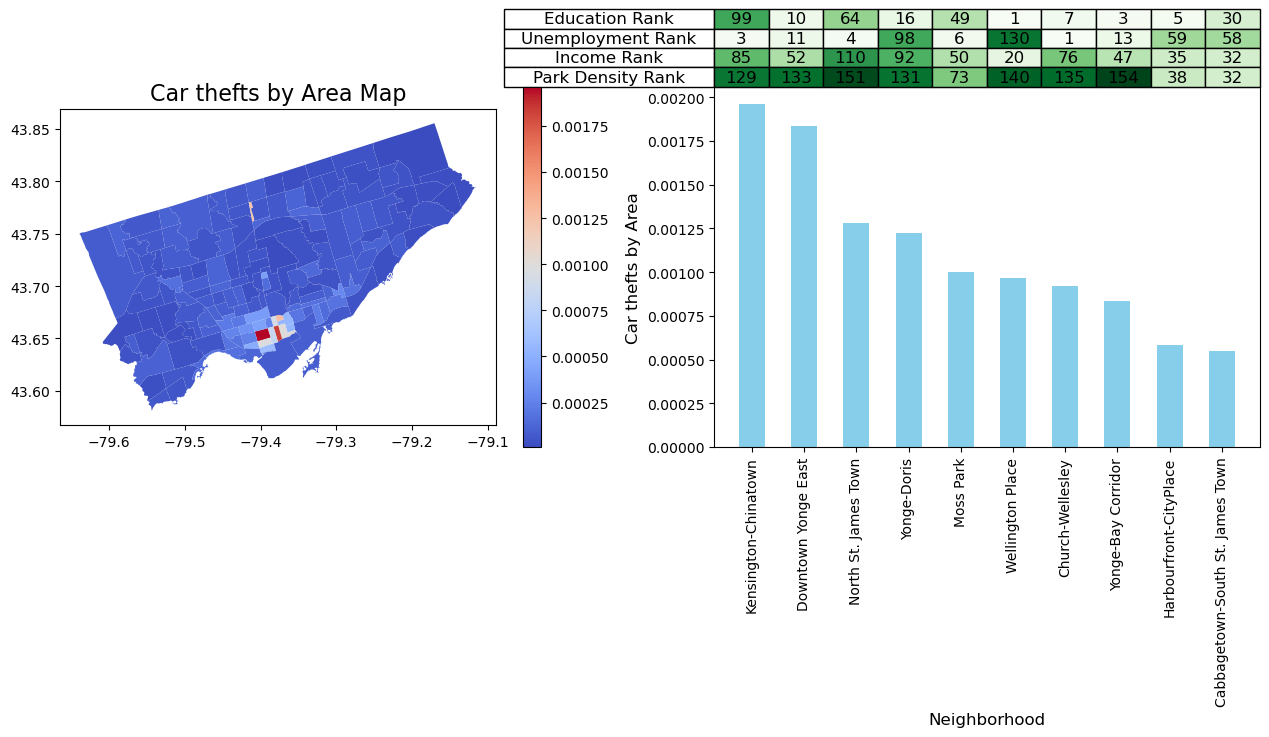

In [19]:
NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by='Car thefts by Area', ascending=False)
top_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)

# Data for the bar chart (top 10 neighborhoods)
labels = top_10_neighbourhoods['Neighbourhood Name']
values = top_10_neighbourhoods['Car thefts by Area']

# Create additional data for the table (for demonstration)
additional_data = top_10_neighbourhoods[['Education Rank', 'Unemployment Rank', 
                                          'Income Rank', 'Park Density Rank']].values

# Create row descriptions
descriptions = ['Education Rank', 'Unemployment Rank', 'Income Rank', 'Park Density Rank']

# Create a figure with two subplots (map and bar+table)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Plot the heatmap on the first axis
NeighbourhoodsWithCrime.plot(column='Car thefts by Area',  # Column to color by
                             cmap='coolwarm',  # Color map to use
                             legend=True,      # Show legend
                             ax=ax[0])         # Plot on the first axis
ax[0].set_title('Car thefts by Area Map', fontsize=16)

# Create the bar chart on the second axis
bars = ax[1].bar(labels, values, color='skyblue', width=0.5)

# Add labels and title to the bar chart
ax[1].set_xlabel('Neighborhood', fontsize=12)
ax[1].set_ylabel('Car thefts by Area', fontsize=12)

# Ensure the data is structured correctly for the table
cell_text = additional_data.T  # Transpose to match columns as rows in the table
columns = labels.tolist()  # Convert to list for proper alignment in the table
rowLabels = descriptions  # The rows correspond to rank descriptions

# Create the colormap for coloring the table cells
colormap = plt.get_cmap('Greens')

# Normalize the additional data values to match the color map
norm = plt.Normalize(np.min(cell_text), np.max(cell_text))  # Normalize data to the colormap

# Create the table above the bar chart
table = ax[1].table(cellText=cell_text, colLabels=None, rowLabels=rowLabels, loc='top', 
                    cellLoc='center', rowLoc='center')

# Apply colors to the cells
for (i, j), val in np.ndenumerate(cell_text):
    # Map the value to the colormap
    color = colormap(norm(val))  # Apply colormap normalization
    table[(i, j)].set_facecolor(color)

# Disable auto font size adjustment for the table
table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(1, 2)

# Adjust layout to make room for the table and keep it aligned with the bars
plt.subplots_adjust(left=0.1, bottom=0.3, top=0.75)  # Increase the 'top' value to make room for the table

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [20]:
#Total

In [21]:
NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by='Total thefts by Area', ascending=True)
bottom_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)
list4 = bottom_10_neighbourhoods['Neighbourhood Name'].tolist();
NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by='Total thefts by Area', ascending=False)
top_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)
list2 = top_10_neighbourhoods['Neighbourhood Name'].tolist();

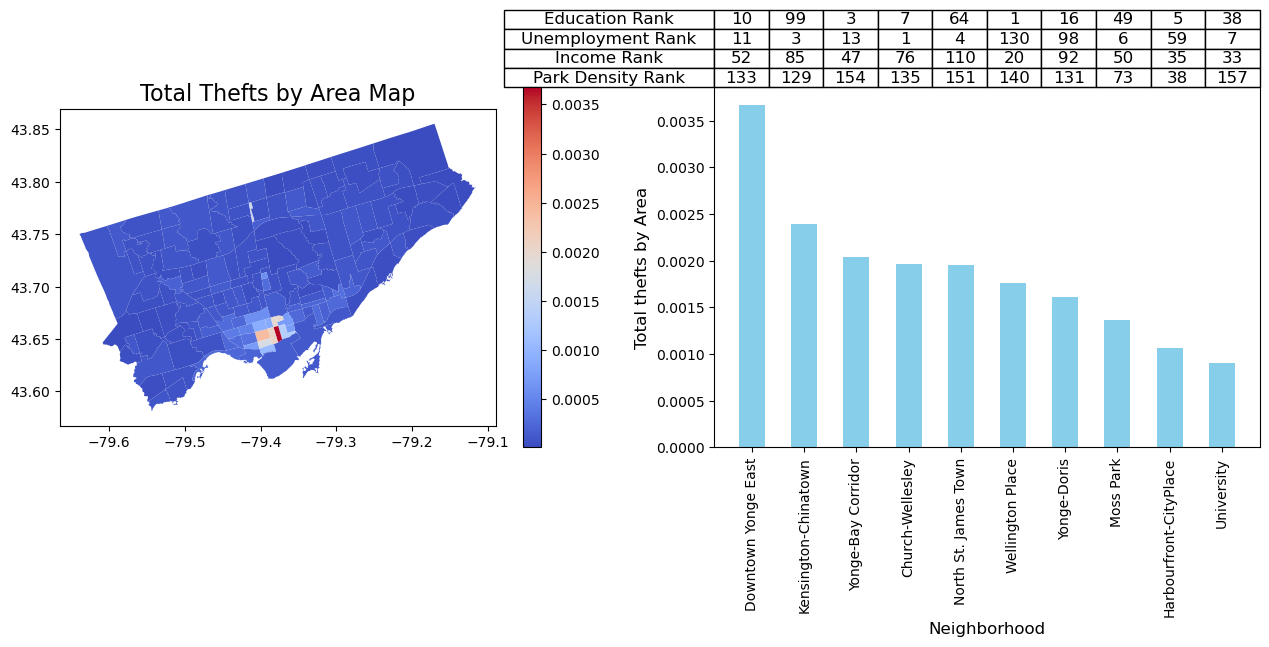

In [22]:
# Data for the bar chart (top 10 neighborhoods)
labels = top_10_neighbourhoods['Neighbourhood Name']
values = top_10_neighbourhoods['Total thefts by Area']

# Create additional data for the table (for demonstration)
# Ensure that the additional columns are available in the DataFrame
additional_data = top_10_neighbourhoods[['Education Rank', 'Unemployment Rank', 
                                          'Income Rank', 'Park Density Rank']].values

# Create row descriptions
descriptions = ['Education Rank', 'Unemployment Rank', 'Income Rank', 'Park Density Rank']

# Create a figure with two subplots (the map will be in the first, the bar+table in the second)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Plot the heatmap (no changes here)
NeighbourhoodsWithCrime.plot(column='Total thefts by Area',  # Column to color by
                             cmap='coolwarm',  # Color map to use
                             legend=True,      # Show legend
                             ax=ax[0])         # Plot on the first axis
ax[0].set_title('Total Thefts by Area Map', fontsize=16)

# Create the bar chart on the second axis
bars = ax[1].bar(labels, values, color='skyblue',width=0.5)

# Add labels and title to the bar chart
ax[1].set_xlabel('Neighborhood', fontsize=12)
ax[1].set_ylabel('Total thefts by Area', fontsize=12)

# Ensure the data is structured correctly for the table
cell_text = additional_data.T  # Transpose to match columns as rows in the table
# The columns will be the neighborhood names
columns = labels.tolist()  # Convert to list for proper alignment in the table
# The rows will correspond to the rank descriptions
rowLabels = descriptions

# Create the table above the bar chart for the top 10 neighborhoods
table = ax[1].table(cellText=cell_text, colLabels=None, rowLabels=rowLabels, loc='top', 
                    cellLoc='center', rowLoc='center')
table.auto_set_font_size(False)  # Disable auto font size adjustment
table.set_fontsize(12) 
table.scale(1, 2)
# Adjust layout to make room for the table and keep it aligned with the bars
plt.subplots_adjust(left=0.1, bottom=0.3, top=0.75)  # Increase the 'top' value to make room for the table

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()

C:\Users\tomer\AppData\Local\Temp\ipykernel_27656\3196784164.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


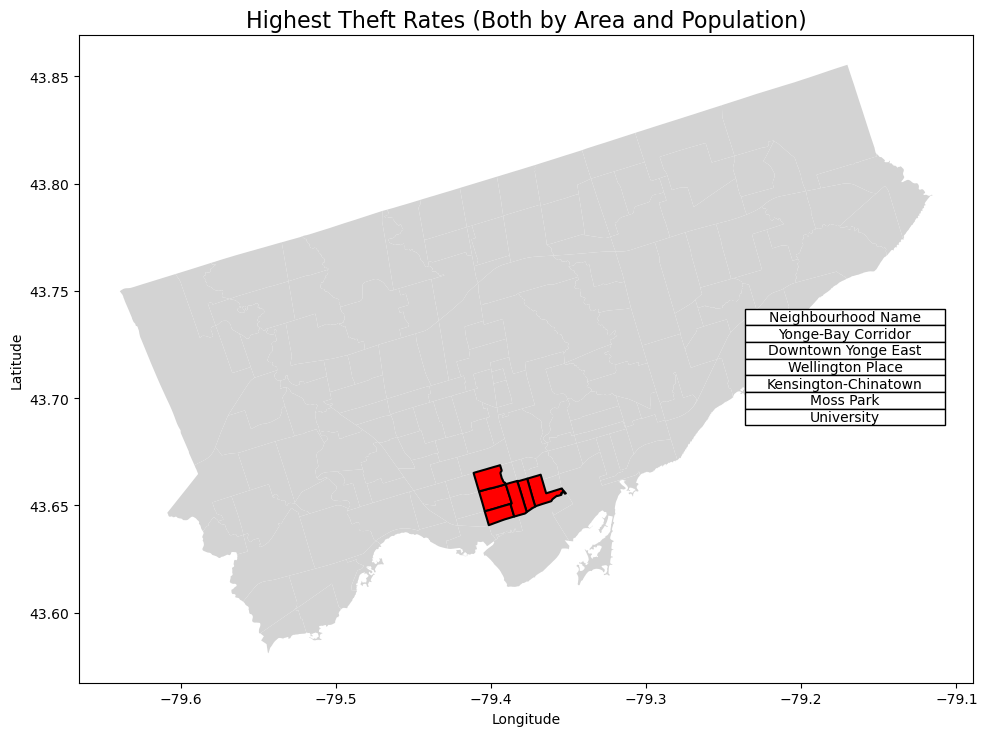

In [23]:
#Highest theft rates in the city
HighestTheftRates = list(set(list1) & set(list2))

highlighted_neighbourhoods = NeighbourhoodsWithCrime[NeighbourhoodsWithCrime['Neighbourhood Name'].isin(HighestTheftRates)]

fig, ax = plt.subplots(figsize=(10, 8))

# Plot all neighbourhoods first
NeighbourhoodsWithCrime.plot(ax=ax, color='lightgray')

# Highlight the neighbourhoods with highest theft rates
highlighted_neighbourhoods.plot(ax=ax, color='red', edgecolor='black', linewidth=1.5)

# Set title and labels
ax.set_title('Highest Theft Rates (Both by Area and Population)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a table to the side of the map
table_data = pd.DataFrame(HighestTheftRates, columns=['Neighbourhood Name'])
table_ax = fig.add_axes([0.75, 0.1, 0.2, 0.8])  # Position of the table in the figure
table_ax.axis('off')
table_ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center')

for (i, j), cell in table.get_celld().items():
    if i == 0:  # First row (header)
        cell.set_text_props(fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\tomer\AppData\Local\Temp\ipykernel_27656\2291578567.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
C:\Users\tomer\AppData\Local\Temp\ipykernel_27656\2291578567.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
C:\Users\tomer\AppData\Local\Temp\ipykernel_27656\2291578567.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
C:\Users\tomer\AppData\Local\Temp\ipykernel_27656\2291578567.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


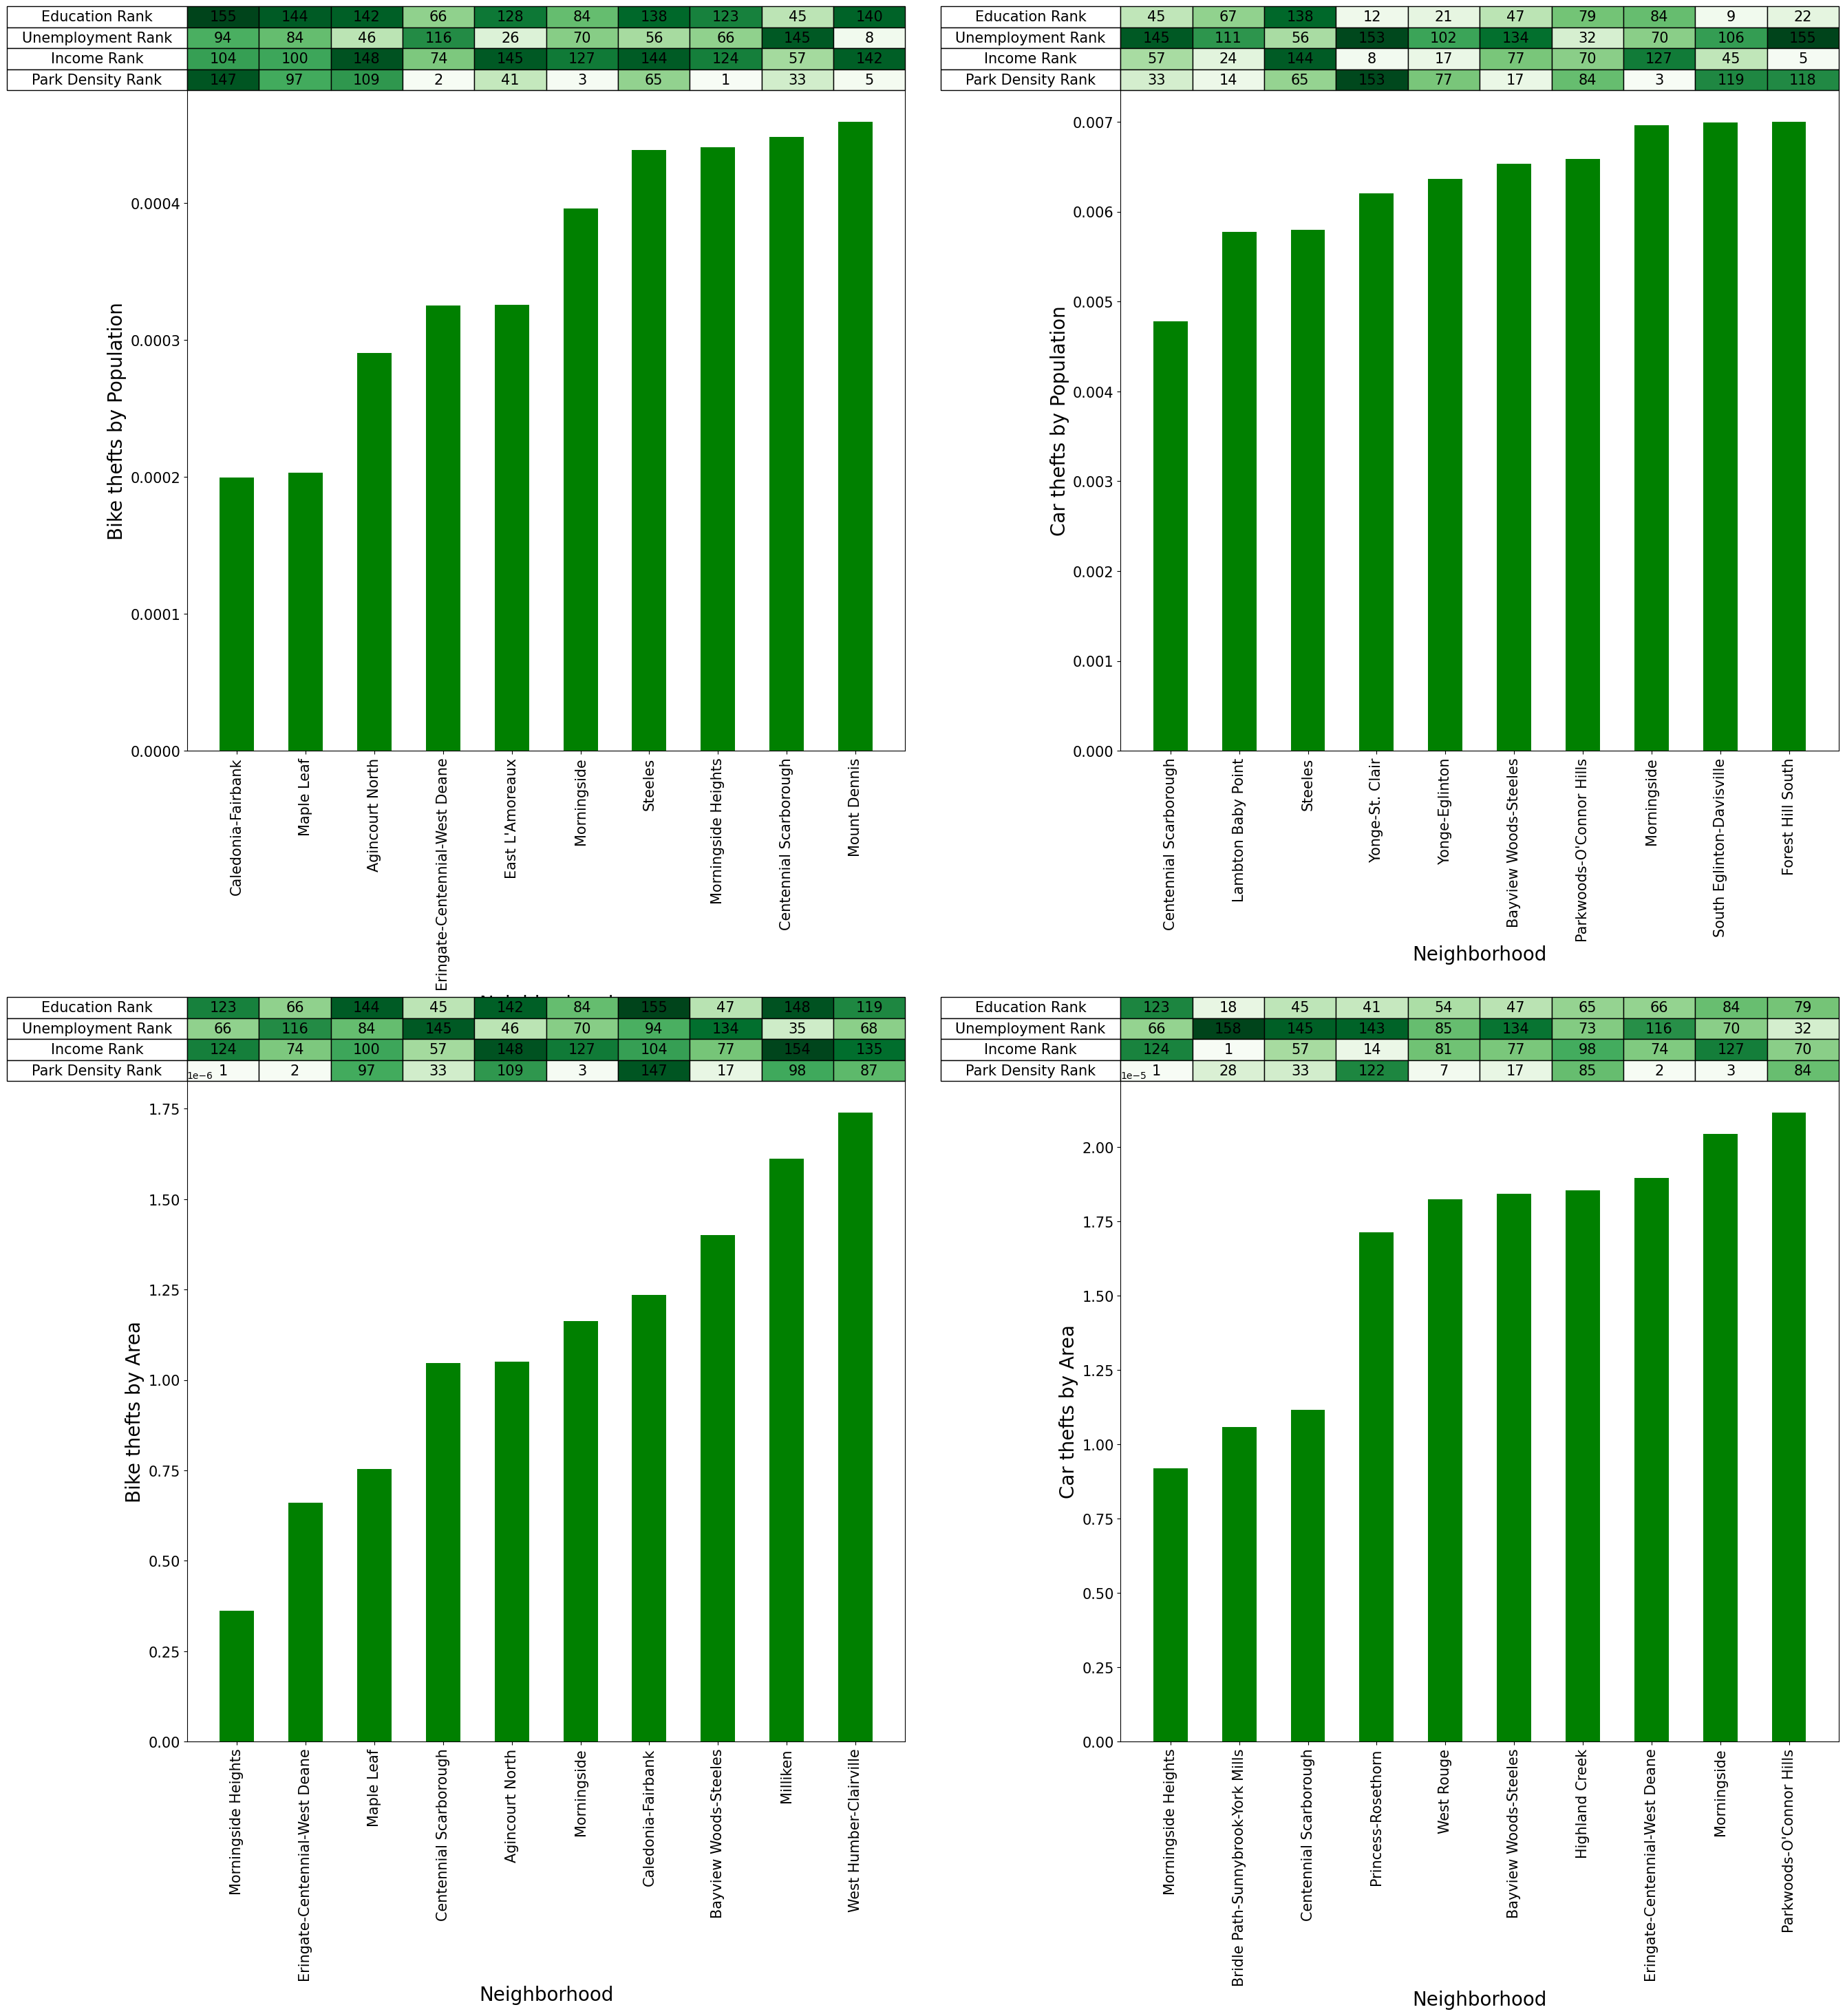

In [24]:
criteria = ['Bike thefts by Population','Car thefts by Population','Bike thefts by Area','Car thefts by Area']

# Create a figure with 4 subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(30, 30))

# Flatten the axs array for easy iteration
axs = axs.flatten()

colormap = plt.get_cmap('Greens')

# Iterate over the subplots to create the bar charts and tables
for i, ax in enumerate(axs):

    # Sort the data based on the current criterion
    NeighbourhoodsWithCrime_sorted = NeighbourhoodsWithCrime.sort_values(by=criteria[i], ascending=True)
    bottom_10_neighbourhoods = NeighbourhoodsWithCrime_sorted.head(10)

    # Data for the bar chart (top 10 neighborhoods)
    labels = bottom_10_neighbourhoods['Neighbourhood Name']
    values = bottom_10_neighbourhoods[criteria[i]]

    # Create additional data for the table (for demonstration)
    additional_data = bottom_10_neighbourhoods[['Education Rank', 'Unemployment Rank', 
                                                'Income Rank', 'Park Density Rank']].values

    # Create row descriptions for the table
    descriptions = ['Education Rank', 'Unemployment Rank', 'Income Rank', 'Park Density Rank']
    
    # Create the bar chart
    ax.bar(labels, values, color='green', width=0.5)

    # Add labels and title to the bar chart
    ax.set_xlabel('Neighborhood', fontsize=20)
    ax.set_ylabel(criteria[i], fontsize=20)
    
    # Ensure that the data is structured correctly for the table
    cell_text = additional_data.T  # Transpose to match columns as rows in the table
    columns = labels.tolist()  # Convert to list for proper alignment in the table
    rowLabels = descriptions  # The rows correspond to rank descriptions
    
        # Normalize the additional data values to match the color map
    norm = plt.Normalize(np.min(cell_text), np.max(cell_text))  # Normalize data to the colormap

    # Create the table above the bar chart
    table = ax.table(cellText=cell_text, colLabels=None, rowLabels=rowLabels, loc='top', 
                    cellLoc='center', rowLoc='center')
    
    # Apply colors to the cells
    for (i, j), val in np.ndenumerate(cell_text):
        # Map the value to the colormap
        color = colormap(norm(val))  # Apply colormap normalization
        table[(i, j)].set_facecolor(color)
    
    table.auto_set_font_size(False)  # Disable auto font size adjustment
    table.set_fontsize(15)  # Adjust font size to fit better in the subplots
    table.scale(1, 2)  # Scale the table size

    ax.tick_params(axis='x', labelsize=15)  # Increase x-tick label font size
    ax.tick_params(axis='y', labelsize=15)  # Increase y-tick label font size
    
    # Rotate x-axis labels to avoid overlap
    ax.set_xticklabels(labels, rotation=90)
    
# Adjust layout to avoid overlapping elements
plt.subplots_adjust(left=0.1, bottom=0.1, top=0.9, hspace=0.5, wspace=0.3)

# Show the plot
plt.show()

C:\Users\tomer\AppData\Local\Temp\ipykernel_27656\999887203.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


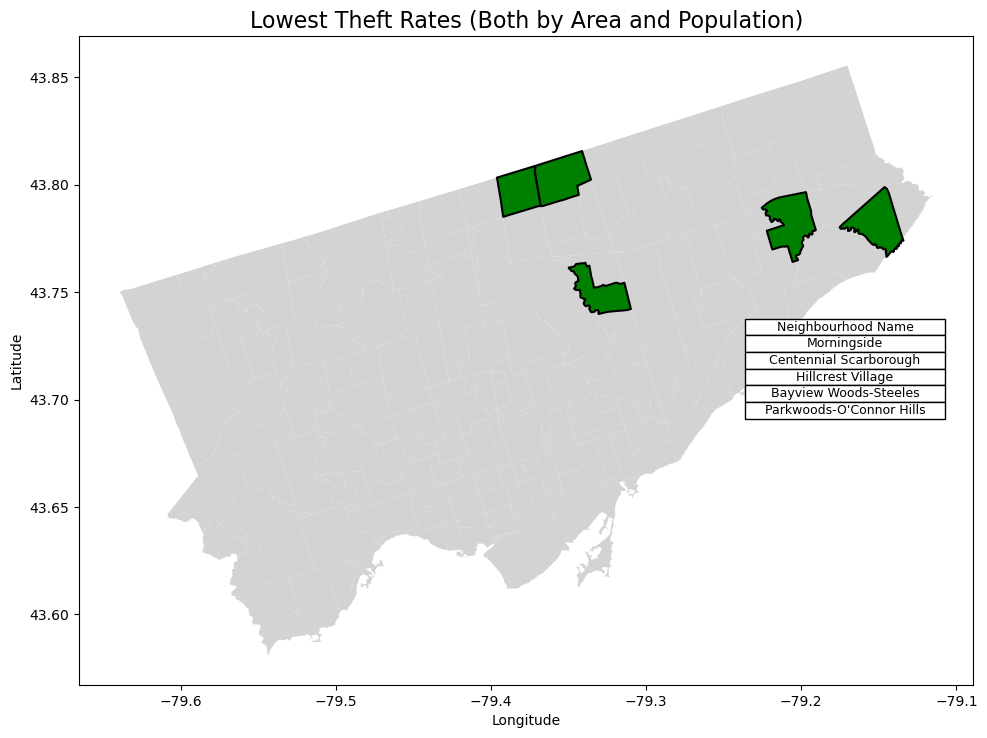

In [25]:
#Lowest theft rates in the city
LowestTheftRates = list(set(list3) & set(list4))

highlighted_neighbourhoods = NeighbourhoodsWithCrime[NeighbourhoodsWithCrime['Neighbourhood Name'].isin(LowestTheftRates)]

fig, ax = plt.subplots(figsize=(10, 8))

# Plot all neighbourhoods first
NeighbourhoodsWithCrime.plot(ax=ax, color='lightgray')

# Highlight the neighbourhoods with highest theft rates
highlighted_neighbourhoods.plot(ax=ax, color='green', edgecolor='black', linewidth=1.5)

# Set title and labels
ax.set_title('Lowest Theft Rates (Both by Area and Population)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a table to the side of the map
table_data = pd.DataFrame(LowestTheftRates, columns=['Neighbourhood Name'])
table_ax = fig.add_axes([0.75, 0.1, 0.2, 0.8])  # Position of the table in the figure
table_ax.axis('off')
table_ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center')

for (i, j), cell in table.get_celld().items():
    if i == 0:  # First row (header)
        cell.set_text_props(fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
!git add Neighbourhood_analysis.ipynb

In [27]:
# Commit the file
!git commit -m "Added code used for neighbourhood analysis"

[main d81b7ae] Added code used for neighbourhood analysis
 1 file changed, 1053 insertions(+)
 create mode 100644 Neighbourhood_analysis.ipynb


In [28]:
!git push origin main

To https://github.com/tamarm/Amateurs-in-the-Dataverse.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/tamarm/Amateurs-in-the-Dataverse.git'
hint: Updates were rejected because the remote contains work that you do not
hint: have locally. This is usually caused by another repository pushing to
hint: the same ref. If you want to integrate the remote changes, use
hint: 'git pull' before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
